In [6]:
import numpy as np

import ND_north_star.src.noise_generators.perlin_noise_generator as PNG

# from ND_north_star.src.noise_generators.perlin_noise_generator import ND_perlin_noise_generator, perlin_M_to_coords, plot_perlin_2D_3D

In [19]:
def normalize_coords(input_coord_array):

    normalized_coord_array = []

    for coord in input_coord_array:
        min_val = coord.min()
        max_val = coord.max()
        range_val = max_val - min_val
        # Avoid division by zero in case all elements are the same
        if range_val != 0:
            normalized = (coord - min_val) / range_val
        else:
            normalized = np.zeros_like(coord)
        normalized_coord_array.append(normalized)

    return normalized_coord_array

In [49]:
import numpy as np

def drop_coords(input_coord_array, values, drop_perc=0.5):
    num_points = len(input_coord_array[0])
    num_points_to_drop = int(num_points * drop_perc)
    
    drop_indices = np.random.choice(num_points, num_points_to_drop, replace=False)

    keep_coord_array = [np.delete(coord, drop_indices, axis=0) for coord in input_coord_array]
    keep_values = np.delete(values, drop_indices, axis=0)

    return keep_coord_array, keep_values

In [32]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import math


def calculate_volume_histogram(coords, bins=10):

    dimensions = len(coords)
    max_hypervolume = 1/math.factorial(dimensions)
    # Transpose the coords array to get a list of points
    points = np.array(coords).T

    # Perform Delaunay triangulation
    tri = Delaunay(points)
    
    # Calculate the volume (hypervolume for dimensions > 3) of each simplex
    volumes = []
    for simplex in tri.simplices:
        vertices = points[simplex]
        # Calculate the volume (hypervolume) of the simplex
        matrix = np.column_stack([vertices, np.ones(len(vertices))])
        volume = np.abs(np.linalg.det(matrix)) / math.factorial(vertices.shape[1] - 1)
        volumes.append(volume)
    
    volumes.append(max_hypervolume)
    # Calculate the histogram of volumes
    hist, bin_edges = np.histogram(volumes, bins=bins)

    # Optionally, plot the histogram
    plt.hist(volumes, bins=bins)
    plt.xlabel('Volume (or Hypervolume)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Tetrahedron Volumes')
    plt.show()

    return hist, bin_edges


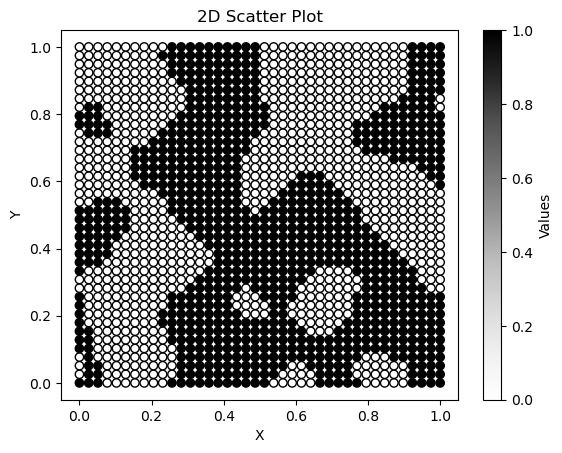

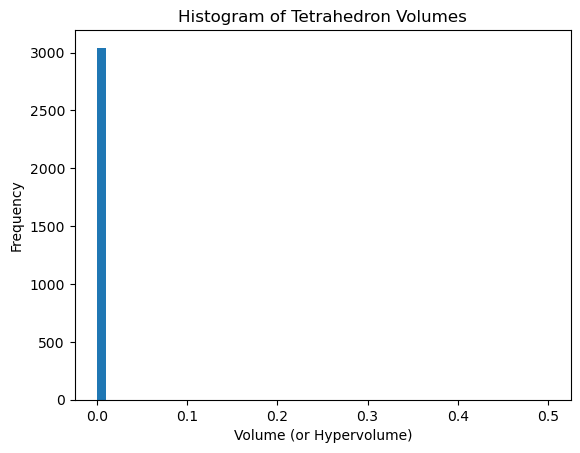

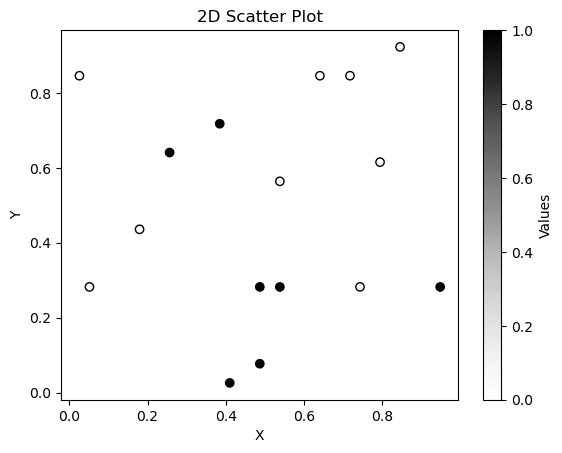

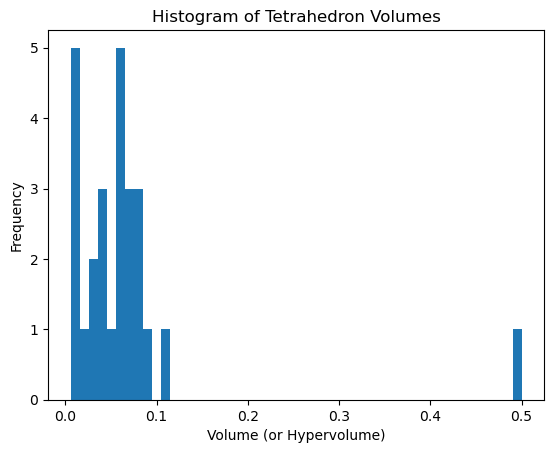

In [56]:
resolution = 40
dimensions = [resolution, resolution]

perlin_noise = PNG.ND_perlin_noise_generator(dimensions, 4, [0,1], [0.5, 0, 1])
coord_array, values = PNG.perlin_M_to_coords(perlin_noise)

normalized_coord_array = normalize_coords(coord_array)
dropped_coords_array, dropped_values = drop_coords(normalized_coord_array, values, 0.99)


# Plot perlin noise coord in x and y coordinates and with intensity values surrounded by a black outline
PNG.plot_perlin_2D_3D(normalized_coord_array, values, 'black')
histogram, bin_edges = calculate_volume_histogram(normalized_coord_array, bins=50)

PNG.plot_perlin_2D_3D(dropped_coords_array, dropped_values, 'black')
histogram, bin_edges = calculate_volume_histogram(dropped_coords_array, bins=50)


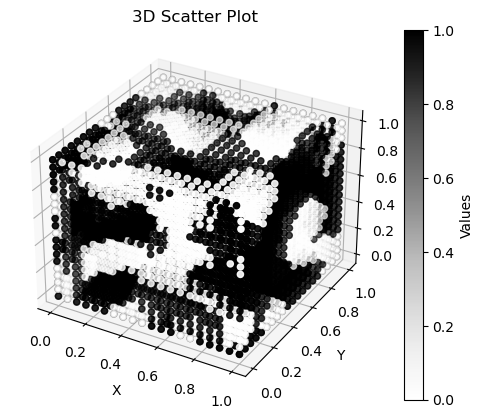

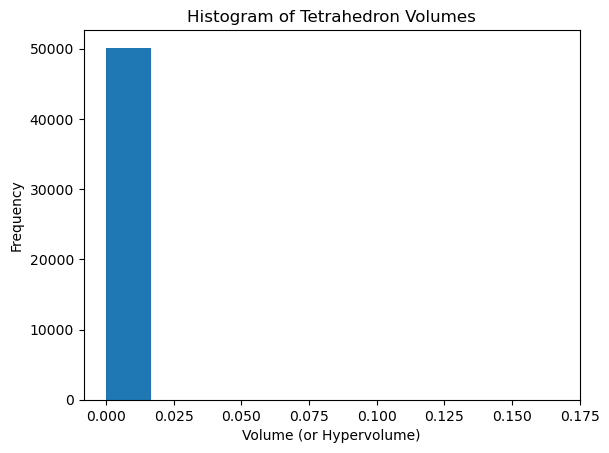

Volume Histogram: [50141     0     0     0     0     0     0     0     0     1]
Bin Edges: [0.         0.01666667 0.03333333 0.05       0.06666667 0.08333333
 0.1        0.11666667 0.13333333 0.15       0.16666667]


In [29]:
resolution = 20
dimensions = [resolution, resolution, resolution]

perlin_noise = PNG.ND_perlin_noise_generator(dimensions, 4, [0,1], [0.5, 0, 1])
coord_array, values = PNG.perlin_M_to_coords(perlin_noise)

normalized_coord_array = normalize_coords(coord_array)
# Plot perlin noise coord in x,y,z coordinates and with intensity values surrounded by a black outline
PNG.plot_perlin_2D_3D(normalized_coord_array, values, 'black')

histogram, bin_edges = calculate_volume_histogram(normalized_coord_array, bins=10)
print(f'Volume Histogram: {histogram}')
print(f'Bin Edges: {bin_edges}')
